### Imports et initialisations

In [5]:
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from clustertools import *

In [27]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/1M_Min_clusters/"

# Bien vérifier que le modèle d'encodage correspond au dataset
clean_dataset_file = "datasets/MillionTweetsMin_NEFU.txt"
encoding_model_file = "models/w2vec_model_d300_global_Min"

raw_dataset_file = "datasets/MillionTweets_NEFU.txt"

### Chargement des données en mémoire

In [7]:
with open(clean_dataset_file, "r") as file:
    lines = file.readlines()
    
# On sépare les messages pour les avoir sous forme de liste de mots.
clean_dataset = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

### Création des échantillons
Ne pas exécuter pour travailler avec toutes les données

In [4]:
sample_size = 5000

idx_list = random.sample(range(len(clean_dataset)), sample_size)
clean_dataset = [clean_dataset[i] for i in idx_list]
raw_dataset = [raw_dataset[i] for i in idx_list]

### Encodage du jeu de données

On charge le modèle depuis le disque

In [8]:
from gensim.models import KeyedVectors

In [28]:
model = KeyedVectors.load(encoding_model_file)
dim = 300

In [10]:
# Encode un message
# msg : liste de chaînes de caractères correspondant aux mots du message
# model : le modèle utilisé pour l'encodage
# dim : la dimension des vecteurs mots dans ce modèle
# Renvoie un vecteur qui est la moyenne de tous les vecteurs correspondants aux mots du message
# Si aucun mot du message n'est dans le modèle, renvoie un vecteur de zéros.
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [11]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg, model, dim) for msg in clean_dataset])

CPU times: user 33.9 s, sys: 564 ms, total: 34.4 s
Wall time: 34.5 s


### Visualisation du dataset

On réalise une réduction de dimension avec PCA afin de visualiser les données dans une grille en deux dimensions

In [12]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 43 s, sys: 11.2 s, total: 54.3 s
Wall time: 8.35 s


In [87]:
# Initialisation des variables globales pour le module clustertools
init_globals(clean_dataset, raw_dataset, two_dim_dataset, cluster_dir)

In [15]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
pca = two_dim_dataset.T

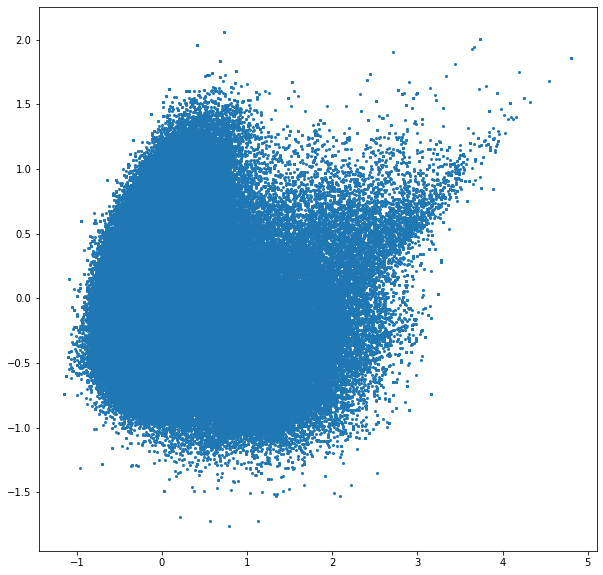

In [16]:
#Affichage des données
plt.scatter(pca[0], pca[1], marker='.')
plt.show()

### Kmeans

Pour mémoire : méthode de calcul du nombre idéal de clusters avec la méthode du coude (elbow method)
```python
sum_of_squared_dist = []
for k in range(1, 60):
    km = KMeans(n_clusters=k)
    km.fit(dataset_encoded)
    sum_of_squared_dist.append(km.inertia_)
    
plt.plot(range(1, 60), sum_of_squared_dist, 'bx-')
plt.show
```

In [17]:
n_clust = 10

In [18]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(dataset_encoded)

CPU times: user 18min 1s, sys: 21.3 s, total: 18min 22s
Wall time: 2min 38s


In [21]:
%%time 
km_pred = kmeans.predict(dataset_encoded)

CPU times: user 1.44 s, sys: 7.12 ms, total: 1.45 s
Wall time: 406 ms


In [22]:
%%time
km_centers = [[r[0] for r in model.similar_by_vector(center)] for center in km_model.cluster_centers_]

CPU times: user 766 ms, sys: 403 ms, total: 1.17 s
Wall time: 184 ms


### Analyse des résultats

In [23]:
%%time
res, wlists, mlists, cmlists, e2dmlists, mfw, hkw, clust_n_msg = parse(km_pred)

CPU times: user 17.8 s, sys: 189 ms, total: 18 s
Wall time: 18 s


In [24]:
print_clusters_info(clust_n_msg, mfw, hkw, km_centers)

Cluster 0 : 93394 messages
610 messages contiennent un mot-clé haineux (soit 0.65%)
Les 20 mots les plus fréquents : j’ai trop mon moi suis toi ma te vais c ah oui j'ai bien ta va t’es là oh bon 
Les mots les plus proches du centre : indécis, j’existe prsq filme. narvalo mood. srx. c’pas bahah d’explication 

Cluster 1 : 169531 messages
1419 messages contiennent un mot-clé haineux (soit 0.84%)
Les 20 mots les plus fréquents : sont nous ils ont aux ou faire comme fait son y cette tous leur même ) bien ces contre sa 
Les mots les plus proches du centre : délaissant l'opposition? faschos décadence. #jesoutienslesfdo l’arabisation parcequ l'islamisation! n'incite contrôlée, 

Cluster 2 : 18525 messages
35 messages contiennent un mot-clé haineux (soit 0.19%)
Les 20 mots les plus fréquents : sfft20160805 #fortune4days testgeohierarchy dc bsgstaliation sisoi naurr #cashapp13plus nsfwtweet bsgstgalore testgeocode sore testplace grité fabulous! bsgsthumping bsgst #boycottmzetxaptxgma255 bsgstan

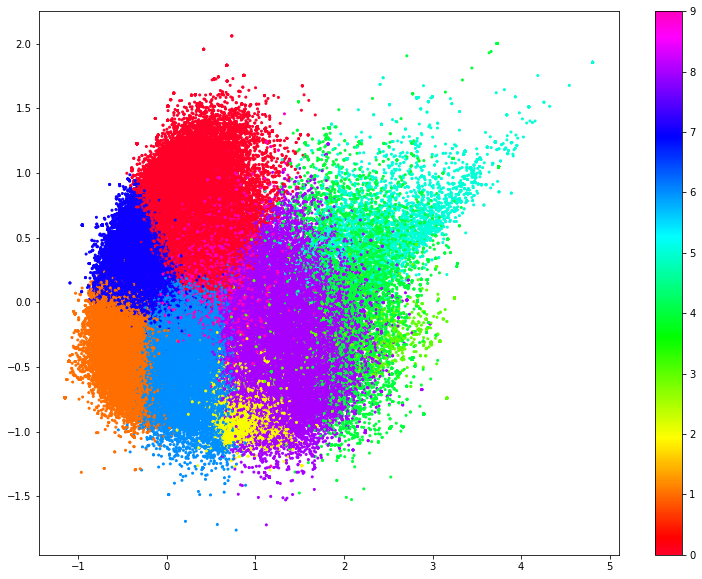

In [74]:
plot_results(km_pred, two_dim_dataset)

### Sauvegarde sur disque

In [61]:
np.save(cluster_dir + "km_" + str(n_clust) + "/clusters_centers.npy" ,km_model.cluster_centers_)

In [78]:
method = "km_10"

# Bien exécuter les fonctions de sauvegarde dans cet ordre car 
save_clusters_msg(cmlists, mlists, e2dmlists, method)
save_clusters_info(clust_n_msg, mfw, hkw, method, km_centers)

### Ou plus rapidement :

- Analyse + sauvegarde :

Cluster 0 : 93394 messages
610 messages contiennent un mot-clé haineux (soit 0.65%)
Les 20 mots les plus fréquents : j’ai trop mon moi suis toi ma te vais c ah oui j'ai bien ta va t’es là oh bon 
Les mots les plus proches du centre : indécis, j’existe prsq filme. narvalo mood. srx. c’pas bahah d’explication 

Cluster 1 : 169531 messages
1419 messages contiennent un mot-clé haineux (soit 0.84%)
Les 20 mots les plus fréquents : sont nous ils ont aux ou faire comme fait son y cette tous leur même ) bien ces contre sa 
Les mots les plus proches du centre : délaissant l'opposition? faschos décadence. #jesoutienslesfdo l’arabisation parcequ l'islamisation! n'incite contrôlée, 

Cluster 2 : 18525 messages
35 messages contiennent un mot-clé haineux (soit 0.19%)
Les 20 mots les plus fréquents : sfft20160805 #fortune4days testgeohierarchy dc bsgstaliation sisoi naurr #cashapp13plus nsfwtweet bsgstgalore testgeocode sore testplace grité fabulous! bsgsthumping bsgst #boycottmzetxaptxgma255 bsgstan

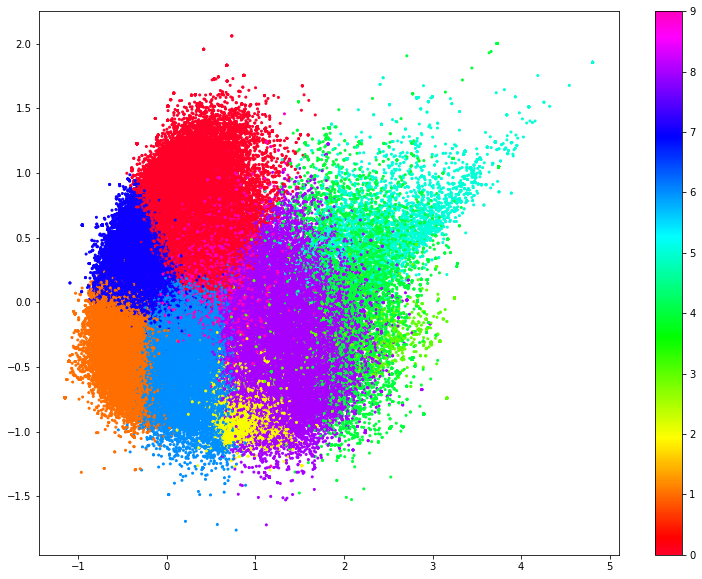

In [105]:
parse_results(km_pred, method, km_centers)

- Analyse sans sauvegarde

Cluster 0 : 93394 messages
610 messages contiennent un mot-clé haineux (soit 0.65%)
Les 20 mots les plus fréquents : j’ai trop mon moi suis toi ma te vais c ah oui j'ai bien ta va t’es là oh bon 
Les mots les plus proches du centre : indécis, j’existe prsq filme. narvalo mood. srx. c’pas bahah d’explication 

Cluster 1 : 169531 messages
1419 messages contiennent un mot-clé haineux (soit 0.84%)
Les 20 mots les plus fréquents : sont nous ils ont aux ou faire comme fait son y cette tous leur même ) bien ces contre sa 
Les mots les plus proches du centre : délaissant l'opposition? faschos décadence. #jesoutienslesfdo l’arabisation parcequ l'islamisation! n'incite contrôlée, 

Cluster 2 : 18525 messages
35 messages contiennent un mot-clé haineux (soit 0.19%)
Les 20 mots les plus fréquents : sfft20160805 #fortune4days testgeohierarchy dc bsgstaliation sisoi naurr #cashapp13plus nsfwtweet bsgstgalore testgeocode sore testplace grité fabulous! bsgsthumping bsgst #boycottmzetxaptxgma255 bsgstan

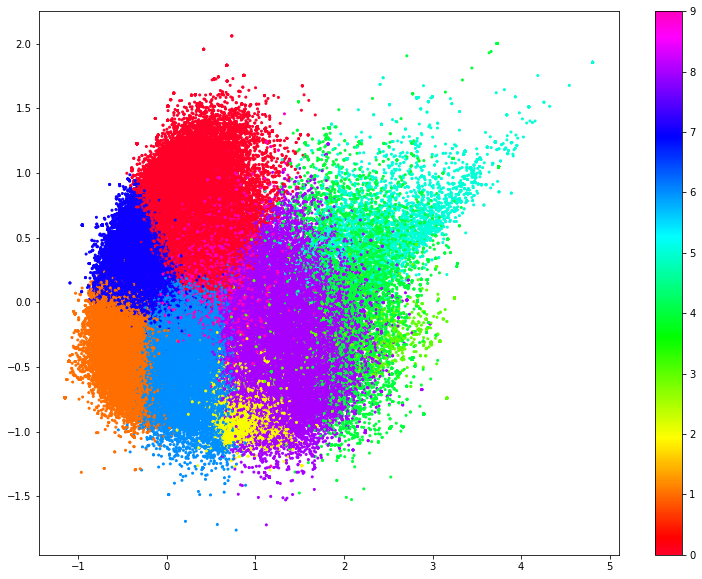

In [104]:
parse_no_save(km_pred, km_centers)